In [6]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
import time

In [7]:
# Initialize API Key from environemtn variables

load_dotenv()
API_KEY = os.getenv("GOOGLE_PLACES_API_KEY")


In [8]:

url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"

params = {
    "location": "39.3995,-84.5613",  # Hamilton, OH
    "radius": 2000,
    "type": "restaurant",
    "key": API_KEY
}

response = requests.get(url, params=params)
data = response.json()

print(data.keys())


dict_keys(['html_attributions', 'next_page_token', 'results', 'status'])


In [9]:
# Confirm that request was executed successfully
data['status']

'OK'

In [10]:
# Find out how many results exist and if there are multiple pages
print(len(data["results"]))
print("Has next page?", "next_page_token" in data)


20
Has next page? True


In [11]:
import json, os

# Save data to a JOSN file for caching
os.makedirs("cache", exist_ok=True)

with open("cache/page1.json", "w") as f:
    json.dump(data, f)


In [12]:
# -------------------------------
# Initialize storage and pagination state
# -------------------------------

# List to collect all place results across pages
all_results = []

# Page counter (Google Places Nearby Search returns up to 3 pages)
page = 1

# Token used to request the next page of results (None for first request)
token = None


# -------------------------------
# Paginated request loop
# -------------------------------

# Loop until there are no more pages or we reach the max page limit
while True:
    
    # If a next_page_token exists, request the next page
    if token:
        # Google requires a short delay before the token becomes valid
        time.sleep(2)
        params = {
            "pagetoken": token,
            "key": API_KEY
        }
    else:
        # First request: search for places near a specific location
        params = {
            "location": "39.3995,-84.5613",  # Downtown Hamilton, OH (lat, lng)
            "radius": 2000,                  # Search radius in meters
            "type": "restaurant",            # Place category
            "key": API_KEY
        }

    # Send request to the Places API and parse the JSON response
    data = requests.get(url, params=params).json()
    print("status:", data["status"])

    # Stop execution if the API returns an error
    if data["status"] != "OK":
        print("error:", data.get("error_message"))
        break
    
    # Append the current page of results to the master list
    all_results.extend(data["results"])

    # Retrieve token for the next page (if available)
    token = data.get("next_page_token")
    page += 1

    # Google Places Nearby Search supports a maximum of 3 pages
    if not token or page > 3:
        break


# -------------------------------
# Final result summary
# -------------------------------

# Print total number of places collected
print("Total places:", len(all_results))


status: OK
status: OK
status: OK
Total places: 56


In [13]:
# Save data to a pandas data frame and then csv file
df = pd.json_normalize(all_results)
df.to_csv("places_restaurants_hamilton.csv", index=False)


In [14]:
# Read data from csv to a dataframe and view top 5 rows
data = pd.read_csv('places_restaurants_hamilton.csv')
data.head()

,business_status,icon,icon_background_color,icon_mask_base_uri,international_phone_number,name,photos,place_id,price_level,rating,...,geometry.location.lat,geometry.location.lng,geometry.viewport.northeast.lat,geometry.viewport.northeast.lng,geometry.viewport.southwest.lat,geometry.viewport.southwest.lng,opening_hours.open_now,plus_code.compound_code,plus_code.global_code,permanently_closed
0,OPERATIONAL,https://maps.gstatic.com/mapfiles/place_api/ic...,#FF9E67,https://maps.gstatic.com/mapfiles/place_api/ic...,+1 513-896-5383,Subway,"[{'height': 1200, 'html_attributions': ['<a hr...",ChIJ-yYlaVlGQIgRHaW4Ovk-L-A,1.0,4.2,...,39.395929,-84.550735,39.397379,-84.549317,39.394681,-84.552015,True,"9CWX+9P Hamilton, OH, USA",86FQ9CWX+9P,NaN
1,OPERATIONAL,https://maps.gstatic.com/mapfiles/place_api/ic...,#FF9E67,https://maps.gstatic.com/mapfiles/place_api/ic...,+1 513-737-0021,Taco Bell,"[{'height': 423, 'html_attributions': ['<a hre...",ChIJu2rp21lGQIgRcBX5Hu2aYio,1.0,3.5,...,39.396721,-84.552845,39.398096,-84.551610,39.395398,-84.554308,True,"9CWW+MV Hamilton, OH, USA",86FQ9CWW+MV,NaN
2,OPERATIONAL,https://maps.gstatic.com/mapfiles/place_api/ic...,#FF9E67,https://maps.gstatic.com/mapfiles/place_api/ic...,+1 513-895-5800,Taqueria El Comal,"[{'height': 3264, 'html_attributions': ['<a hr...",ChIJtS_93llGQIgR8mpgLDTaVvc,1.0,4.4,...,39.396972,-84.553393,39.398356,-84.552091,39.395658,-84.554789,True,"9CWW+QJ Hamilton, OH, USA",86FQ9CWW+QJ,NaN
3,OPERATIONAL,https://maps.gstatic.com/mapfiles/place_api/ic...,#FF9E67,https://maps.gstatic.com/mapfiles/place_api/ic...,+1 513-892-3890,The Drink Tavern,"[{'height': 5248, 'html_attributions': ['<a hr...",ChIJtwLSQvlGQIgRy2kyZzkym8o,1.0,4.4,...,39.405365,-84.557813,39.406624,-84.556445,39.403926,-84.559143,True,"CC4R+4V Hamilton, OH, USA",86FQCC4R+4V,NaN
4,OPERATIONAL,https://maps.gstatic.com/mapfiles/place_api/ic...,#FF9E67,https://maps.gstatic.com/mapfiles/place_api/ic...,+1 513-896-6200,Plaza One Grille,"[{'height': 1365, 'html_attributions': ['<a hr...",ChIJ0e-K7v9GQIgRUHHLBr_FNb8,NaN,4.0,...,39.401887,-84.563190,39.403216,-84.561677,39.400518,-84.564375,True,"CC2P+QP Hamilton, OH, USA",86FQCC2P+QP,NaN


In [15]:
# Print a few columns
data[['name', 'international_phone_number', 'price_level', 'rating']].head()

,name,international_phone_number,price_level,rating
0,Subway,+1 513-896-5383,1.0,4.2
1,Taco Bell,+1 513-737-0021,1.0,3.5
2,Taqueria El Comal,+1 513-895-5800,1.0,4.4
3,The Drink Tavern,+1 513-892-3890,1.0,4.4
4,Plaza One Grille,+1 513-896-6200,NaN,4.0


In [16]:
# Define Downtown Hamiltons Coordinates, Same as for radius distance for restaraunts
DOWNTOWN_LAT = 39.3995
DOWNTOWN_LNG = -84.5613


In [17]:
# Create a function to calculate a restaraunts distance from downtown

import numpy as np

def haversine_km(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points
    on the Earth (specified in decimal degrees).
    Returns distance in kilometers.
    """
    R = 6371  # Earth radius in kilometers

    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    return R * c


In [18]:
# Use Haversine function to calulate distances from downtown for each restaraunt in a new column
df["distance_to_downtown_km"] = haversine_km(
    DOWNTOWN_LAT,
    DOWNTOWN_LNG,
    df["geometry.location.lat"],
    df["geometry.location.lng"]
)

In [19]:
# Show restaraunt distances in descending order
df[["name", "distance_to_downtown_km"]].sort_values("distance_to_downtown_km", ascending=False).head()


,name,distance_to_downtown_km
55,Third Eye Brewing Company Hamilton,1.769544
54,El Sabrozon Snack and Bar,1.762368
11,Pohlman Lanes & Family Entertainment Complex,1.744046
53,Deli's Cafe,1.600525
52,El TacoNazo,1.572409


<Axes: xlabel='distance_to_downtown_km', ylabel='rating'>

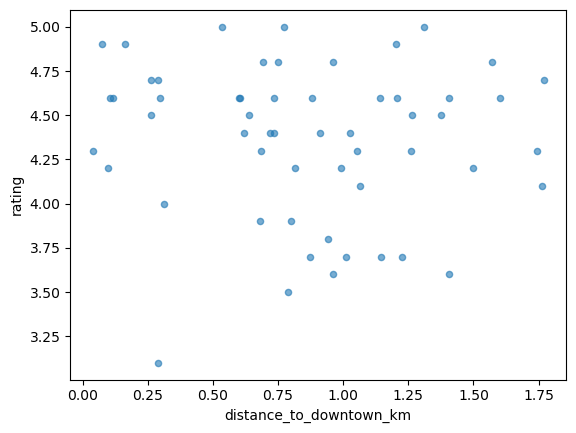

In [20]:
df.plot.scatter(
    x="distance_to_downtown_km",
    y="rating",
    alpha=0.6
)


In [ ]:
# Create bins to bin restaraunts by distance from downtown
df["distance_band"] = pd.cut(
    df["distance_to_downtown_km"],
    bins=[0, 0.5, 1, 1.5, 2, 3],
    labels=["0-0.5km", "0.5-1km", "1-1.5km", "1.5-2km", "2-3km"]
)


In [25]:
# Group by bin and rating
df.groupby("distance_band")["rating"].mean()




C:\Users\brand\AppData\Local\Temp\ipykernel_27040\1725469197.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("distance_band")["rating"].mean()


distance_band
0-0.5km    4.425000
0.5-1km    4.347826
1-1.5km    4.293750
1.5-2km    4.500000
2-3km           NaN
Name: rating, dtype: float64

In [ ]:
# Checking Counts per band
df.groupby("distance_band")["rating"].agg(["count", "mean"])



C:\Users\brand\AppData\Local\Temp\ipykernel_27040\460550434.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("distance_band")["rating"].agg(["count", "mean"])


,count,mean
distance_band,,
0-0.5km,12,4.425000
0.5-1km,23,4.347826
1-1.5km,16,4.293750
1.5-2km,5,4.500000
2-3km,0,NaN
